# Quickdraw Data

If machine learning is rocket science then data is your fuel! So before
doing anything we will have a close look at the data available and spend
some time bringing it into the "right" form (i.e.
[tf.train.Example](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/train/Example)).

That's why we start by spending quite a lot on this notebook, downloading
the data, understanding it, and transforming it into the right format for
Tensorflow.

The data used in this workshop is taken from Google's quickdraw (click on
the images to see loads of examples):

https://quickdraw.withgoogle.com/data

Table of contents:

- [ 1 Get the data](#1-Get-the-data)
- [ 2 Inspect the data](#2-Inspect-the-data)
- [ 3 Rasterize](#3-Rasterize)
- [ 4 tf.train.Example data format](#4-tf.train.Example-data-format)
- [ 5 Create dataset](#5-Create-dataset)
- [ 6 Prepare dataset for RNN – bonus!](#6-Prepare-dataset-for-RNN-%E2%80%93-bonus!)

In [1]:
import base64, io, itertools, json, os, random, re, time
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from PIL import Image, ImageDraw
from IPython import display
from six.moves.urllib import request
from xml.dom import minidom

%matplotlib inline
# Always make sure you are using running the expected version.
# There are considerable differences between versions...
tf.__version__

'1.4.1'

# 1 Get the data

In this section we download a set of raw data files from the web.

In [2]:
# Retrieve list of classes.

def list_bucket(bucket, regexp='.*'):
    """Returns a (filtered) list of Keys in specified GCE bucket."""
    keys = []
    fh = request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
print 'available: (%d)' % len(all_ndjsons)
print ' '.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons])

available: (309)
The Eiffel Tower The Great Wall of China The Mona Lisa aircraft carrier airplane alarm clock ambulance angel animal migration ant anvil apple arm asparagus axe backpack banana bandage barn baseball bat baseball basket basketball bat bathtub beach bear beard bed bee belt bench bicycle binoculars bird birthday cake blackberry blueberry book boomerang bottlecap bowtie bracelet brain bread bridge broccoli broom bucket bulldozer bus bush butterfly cactus cake calculator calendar camel camera camouflage campfire candle cannon canoe car carrot castle cat ceiling fan cell phone cello chair chandelier church circle clarinet clock cloud coffee cup compass computer cookie cooler couch cow crab crayon crocodile crown cruise ship cup diamond dishwasher diving board dog dolphin donut door dragon dresser drill drums duck dumbbell ear elbow elephant envelope eraser eye eyeglasses face fan feather fence finger fire hydrant fireplace firetruck fish flamingo flashlight flip flops floor l

In [3]:
# Store all data locally in this directory.
data_path = '../data'

# Mini group of two animals.
pets = ['cat', 'dog']

# Somewhat larger group of zoo animals.
zoo = ['elephant', 'giraffe', 'kangaroo', 'lion', 'monkey', 'panda',
       'penguin', 'rhinoceros', 'tiger', 'zebra']

# Even larger group of all animals.
animals = ['bat', 'bird', 'butterfly', 'camel', 'cat', 'cow', 'crab',
           'crocodile', 'dog', 'dolphin', 'duck', 'elephant', 'fish',
           'frog', 'giraffe', 'hedgehog', 'horse', 'kangaroo', 'lion',
           'lobster', 'monkey', 'mosquito', 'mouse', 'octopus', 'owl',
           'panda', 'parrot', 'penguin', 'pig', 'rabbit', 'raccoon',
           'rhinoceros', 'scorpion', 'sea turtle', 'shark', 'sheep',
           'snail', 'spider', 'squirrel', 'teddy-bear', 'tiger',
           'whale', 'zebra']

# Create your own group -- the more classes you include the more challenging
# the classification task will be...

# Choose one of above groups for remainder of workshop.
# Note: This will result in ~100MB of download per class.
classes, classes_name = zoo, 'zoo'

In [4]:
# Download above chosen group.

def valid_ndjson(filename):
    """Checks presence + completeness of .ndjson file."""
    try:
        json.loads(open(filename).readlines()[-1])
        return True
    except ValueError, IOError:
        return False

def retrieve(bucket, key, filename):
    """Returns a file specified by its Key from a GCE bucket."""
    url = 'https://storage.googleapis.com/%s/%s' % (bucket, key)
    if not os.path.isfile(filename):
        request.urlretrieve(url=url, filename=filename)
    while not valid_ndjson(filename):
        print '*** Corrupted download (%.2f MB), retrying...' % (os.path.getsize(filename) / 2.**20)
        request.urlretrieve(url=url, filename=filename)

if not os.path.exists(data_path):
    os.mkdir(data_path)

print '\n%d classes:' % len(classes)

for name in classes:
    print name,
    dst = '%s/%s.ndjson' % (data_path, name)
    retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
    print '%.2f MB' % (os.path.getsize(dst) / 2.**20)

print '\nDONE :)'


10 classes:
elephant 70.86 MB
giraffe 58.27 MB
kangaroo 96.06 MB
lion 90.47 MB
monkey 91.05 MB
panda 97.04 MB
penguin 137.90 MB
rhinoceros 92.20 MB
tiger 86.09 MB
zebra 92.10 MB

DONE :)


# 2 Inspect the data

What is the format of the downloaded files?

In [5]:
# So let's check out the downloaded files...
!ls $data_path

README.md    dataset_stroke   kangaroo.ndjson  penguin.ndjson	  tiger.ndjson
bat.ndjson   dog.ndjson       lion.ndjson      rhinoceros.ndjson  zebra.ndjson
cat.ndjson   elephant.ndjson  monkey.ndjson    sea lion.ndjson	  zoo_img
dataset_img  giraffe.ndjson   panda.ndjson     sea turtle.ndjson  zoo_stroke


In [6]:
# What is the NDJSON file format?
# Seems to be one JSON dictionary per line...
path = tf.gfile.Glob(os.path.join(data_path, '*.ndjson'))[1]
print file(path).read()[:1000] + '...'

{"word":"cat","countrycode":"VE","timestamp":"2017-03-02 23:25:10.07453 UTC","recognized":true,"key_id":"5201136883597312","drawing":[[[130,113,99,109,76,64,55,48,48,51,59,86,133,154,170,203,214,217,215,208,186,176,162,157,132],[72,40,27,79,82,88,100,120,134,152,165,184,189,186,179,152,131,114,100,89,76,0,31,65,70]],[[76,28,7],[136,128,128]],[[76,23,0],[160,164,175]],[[87,52,37],[175,191,204]],[[174,220,246,251],[134,132,136,139]],[[175,255],[147,168]],[[171,208,215],[164,198,210]],[[130,110,108,111,130,139,139,119],[129,134,137,144,148,144,136,130]],[[107,106],[96,113]]]}
{"word":"cat","countrycode":"BR","timestamp":"2017-03-26 18:43:54.78083 UTC","recognized":true,"key_id":"4647694628814848","drawing":[[[222,196,176,173,179,191,233,251,255,250,231,219],[31,32,43,60,72,79,79,69,54,35,27,27]],[[176,198,203],[42,0,26]],[[219,238,249,252,252],[29,11,5,16,43]],[[190,188,191,200,204,200],[44,45,49,51,43,41]],[[233,228,233,241,243,231],[44,48,53,53,46,43]],[[203,208,213,218,227,234],[63,69,

In [7]:
# Parse single line.
data_json = json.loads(file(path).readline())
data_json.keys()

[u'word', u'countrycode', u'timestamp', u'recognized', u'key_id', u'drawing']

In [8]:
# So we have some meta information...
for k, v in data_json.iteritems():
    if k != 'drawing':
        print '%20s   ->   %s' % (k, v)

                word   ->   cat
         countrycode   ->   VE
           timestamp   ->   2017-03-02 23:25:10.07453 UTC
          recognized   ->   True
              key_id   ->   5201136883597312


In [9]:
# ...and the actual drawing.
drawing = data_json['drawing']
# The drawing consists of a series of strokes:
[np.array(stroke).shape for stroke in drawing]

[(2, 25), (2, 3), (2, 3), (2, 3), (2, 4), (2, 2), (2, 3), (2, 8), (2, 2)]

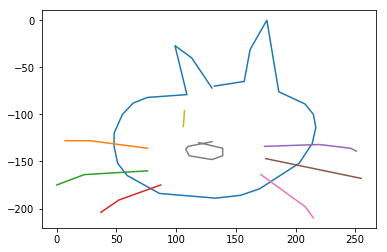

In [10]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:
for stroke in drawing:
    pyplot.plot(np.array(stroke[0]), -np.array(stroke[1]))
# Would YOU recognize this drawing successfully?

In [11]:
%%time
# Some more code to load many sketches at once.
# Let's ignore the difficult "unrecognized" sketches for now...
# (i.e. unrecognized by the official quickdraw classifier)

def convert(line):
    """Converts single line to JSON + converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d

def loaditer(name, unrecognized=False):
    """Returns iterable of drawings in specified file.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    for line in open('%s/%s.ndjson' % (data_path, name)):
        d = convert(line)
        if d['recognized'] or unrecognized:
            yield d

def loadn(name, n, unrecognized=False):
    """Returns list of drawings.

    Args:
      name: Name of the downloaded object (e.g. "elephant").
      n: Number of drawings to load.
      unrecognized: Whether to include drawings that were not recognized
          by Google AI (i.e. the hard ones).
    """
    it = loaditer(name, unrecognized=unrecognized)
    return list(itertools.islice(it, 0, n))

print 'loading some "%s"...' % classes[0]
sample = loadn(classes[0], 100)

loading some "elephant"...
CPU times: user 40 ms, sys: 180 ms, total: 220 ms
Wall time: 43.8 ms


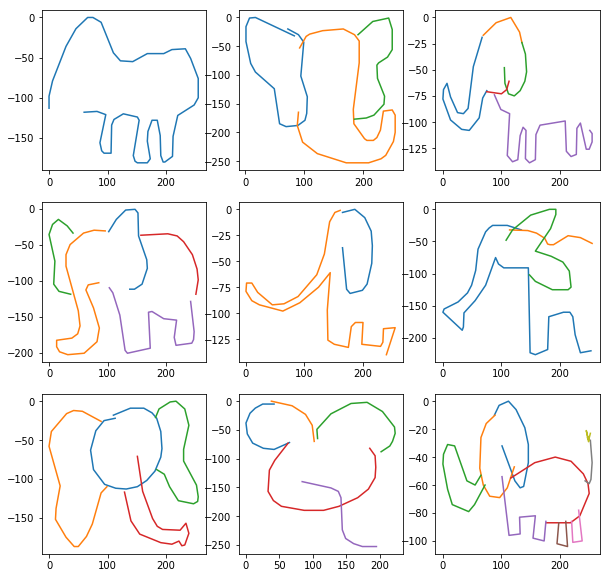

In [12]:
# Some more drawings...
pyplot.figure(figsize=(10, 10))
n = 3
for x in range(n):
    for y in range(n):
        i = x * n + y
        pyplot.subplot(n, n, i + 1)
        for stroke in sample[i]['drawing']:
            pyplot.plot(np.array(stroke[0]), -np.array(stroke[1]))

# 3 Rasterize

Idea: After converting the raw drawing data into rasterized images, we can
use [MNIST](https://www.tensorflow.org/get_started/mnist/beginners)-like
image processing to classify the drawings.

In [13]:
%%writefile _derived/1_json_to_img.py
# (Written into separate file for sharing between notebooks.)

# Function that converts drawing (specified by individual strokes)
# to a rendered black/white image.

def json_to_img(drawing, img_sz=64, lw=3, maximize=True):
    img = Image.new('L', (img_sz, img_sz))
    draw = ImageDraw.Draw(img)
    lines = np.array([
        stroke[0:2, i:i+2]
        for stroke in drawing['drawing']
        for i in range(stroke.shape[1] - 1)
    ], dtype=np.float32)
    if maximize:
        for i in range(2):
            min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
            lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
    else:
        lines /= 1024
    for line in lines:
        draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
    return img

Overwriting _derived/1_json_to_img.py



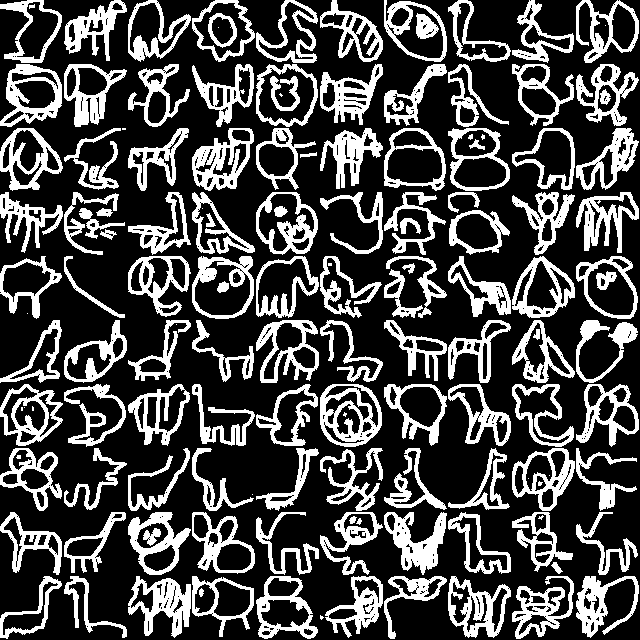

In [14]:
# (Load code from previous cell -- make sure to have executed above cell first.)
%run -i _derived/1_json_to_img.py

# Show some examples.

def showimg(img):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img, 'L')
    b = io.BytesIO()
    img.convert('RGB').save(b, format='png')
    enc = base64.b64encode(b.getvalue()).decode('utf-8')
    display.display(display.HTML(
        '<img src="data:image/png;base64,%s">' % enc))

# Fetch some images + shuffle order.
rows, cols = 10, 10
n_per_class = rows * cols // len(classes) + 1
drawings_matrix = [loadn(name, rows*cols) for name in classes]
drawings_list = reduce(lambda x, y: x + y, drawings_matrix, [])
drawings_list = np.random.permutation(drawings_list)

# Create mosaic of rendered images.
lw = 4
img_sz = 64
tableau = np.zeros((img_sz * rows, img_sz * cols), dtype=np.uint8)
for y in range(rows):
    for x in range(cols):
        i = y * rows + x
        img = json_to_img(drawings_list[i], img_sz=img_sz, lw=lw, maximize=True)
        tableau[y*img_sz:(y+1)*img_sz, x*img_sz:(x+1)*img_sz] = np.asarray(img)

showimg(tableau)

# 4 tf.train.Example data format

Tensorflow's "native" format for data storage is the `tf.train.Example`
[protocol buffer](https://en.wikipedia.org/wiki/Protocol_Buffers).

In this section we briefly explore the API needed to access the data
inside the `tf.train.Example` protocol buffer. It's **not necessary** to read
through the
[Python API documentation](https://developers.google.com/protocol-buffers/docs/pythontutorial).

In [15]:
# Create a new (empty) instance.
example = tf.train.Example()
# (empty example will print nothing)
print example

In [16]:
# An example contains a map from feature name to "Feature".
# Every "Feature" contains a list of elements of the same
# type, which is one of:
# - bytes_list (similar to Python's "str")
# - float_list (float number)
# - int64_list (integer number)

# These values can be accessed as follows (no need to understand
# details):

# Add float value "3.1416" to feature "magic_numbers"
example.features.feature['magic_numbers'].float_list.value.append(3.1416)
# Add some more values to the float list "magic_numbers".
example.features.feature['magic_numbers'].float_list.value.extend([2.7183, 1.4142, 1.6180])

### YOUR ACTION REQUIRED:
# Create a second feature named "adversaries" and add the elements
# "Alice" and "Bob".
example.features.feature['adversaries'].bytes_list.value.extend(['Alice', 'Bob']) #example.features.feature['adversaries'].

# This will now print a serialized representation of our protocol buffer
# with features "magic_numbers" and "adversaries" set...
print example

# .. et voila : that's all you need to know about protocol buffers
# for this workshop.

features {
  feature {
    key: "adversaries"
    value {
      bytes_list {
        value: "Alice"
        value: "Bob"
      }
    }
  }
  feature {
    key: "magic_numbers"
    value {
      float_list {
        value: 3.14159989357
        value: 2.71830010414
        value: 1.41419994831
        value: 1.61800003052
      }
    }
  }
}



# 5 Create dataset

Now let's create a "dataset" of `tf.train.Example`
[protocol buffers](https://developers.google.com/protocol-buffers/) ("protos").

A single example contains all the information for a drawing (i.e. rasterized
image, label, and meta information).

A dataset consists of non-overlapping sets of examples that will be used for
training and evaluation of the classifier (the "test" set will be used for the
final evaluation). Because these files can quickly become very large, we
"shard" them into multiple smaller files of equal size.

In [17]:
# Let's first check how many [recognized=True] examples we have in each class.
# Depending on your choice of classes you could generate up to 200k examples...
for name in classes:
    print name, len(list(open('%s/%s.ndjson' % (data_path, name)))), 'recognized', len(list(loaditer(name)))

elephant 126969 recognized 104986
giraffe 127182 recognized 122396
kangaroo 174470 recognized 152511
lion 120949 recognized 98976
monkey 127633 recognized 105650
panda 113613 recognized 94814
penguin 253791 recognized 231826
rhinoceros 188484 recognized 166539
tiger 121067 recognized 110177
zebra 144608 recognized 127159


In [18]:
# Helper code to create sharded recordio files.
# (No need to read through this.)

# Well... Since you continue to read through this cell, I could as
# well explain in more detail what it is about :-)
# Because we work with large amounts of data, we will create "sharded"
# files, that is, we split a single dataset into a number of files, like
# train-00000-of-00005, ..., train-00004-of-00005 (if we're using 5 shards).
# This way we have smaller individual files, and we can also easily access
# e.g. 20% of all data, or have 5 threads reading through the data
# simultaneously.

# The code in this cell simply takes a list of iterators and then
# randomly distributes the values returned by these iterators into sharded
# datasets (e.g. a train/eval/test split).

def rand_key(counts):
    """Returns a random key from "counts", using values as distribution."""
    r = random.randint(0, sum(counts.values()))
    for key, count in counts.iteritems():
        if r > count or count == 0:
            r -= count
        else:
            counts[key] -= 1
            return key

def make_sharded_files(make_example, path, classes, iters, splits,
                       shards=10, overwrite=False, report_dt=10):
    """Create sharded files from "iters".

    Args:
      make_example: Converts object returned by elements of "iters"
          to tf.train.Example() proto.
      path: Directory that will contain recordio files.
      classes: Names of classes, will be written to "labels.txt".
      splits: Dictionary mapping filename to number of examples (of
          every class).
      shards: Number of files to be created per split.
      overwrite: Whether a pre-existing directory should be overwritten.
      report_dt: Number of seconds between status updates (0=no updates).

    Returns:
      Total number of examples written to disk (this should be equal to
      the number of classes times the sum of the number of examples of
      all the splits).
    """
    assert len(iters) == len(classes)
    if not os.path.exists(path):
        os.makedirs(path)
    paths = {
        split: ['%s/%s-%05d-of-%05d' % (path, split, i, shards)
                for i in range(shards)]
        for split in splits
    }
    assert overwrite or not os.path.exists(paths.values()[0][0])
    writers = {
        split: [tf.python_io.TFRecordWriter(ps[i]) for i in range(shards)]
        for split, ps in paths.iteritems()
    }
    t0 = time.time()
    n = sum(splits.values())
    examples = 0
    for i in range(n):
        split = rand_key(splits)
        writer = writers[split][splits[split] % shards]
        for j in range(len(classes)):
            example = make_example(j, iters[j].next())
            writer.write(example.SerializeToString())
            examples += 1
        remaining = sum(splits.values())
        if report_dt > 0 and time.time() - t0 > report_dt:
            print 'processed %d/%d (%.2f%%)' % (i, n, 100. * i / n)
            t0 = time.time()
    for split in splits:
        for writer in writers[split]:
            writer.close()
    with open('%s/labels.txt' % path, 'w') as f:
        f.write('\n'.join(classes))
    return examples

In [19]:
%%writefile _derived/1_make_example_img.py
# (Written into separate file for sharing between notebooks.)

# Convert drawing tf.train.Example proto.
# Uses json_to_img() from previous cell to create raster image.

def make_example_img(label, drawing):
    example = tf.train.Example()
    example.features.feature['label'].int64_list.value.append(label)
    img_64 = np.asarray(json_to_img(drawing, img_sz=64, lw=4, maximize=True)).reshape(-1)
    example.features.feature['img_64'].int64_list.value.extend(img_64)
    example.features.feature['countrycode'].bytes_list.value.append(drawing['countrycode'].encode())
    example.features.feature['recognized'].int64_list.value.append(drawing['recognized'])
    example.features.feature['word'].bytes_list.value.append(drawing['word'].encode())
    ts = drawing['timestamp']
    ts = time.mktime(time.strptime(ts[:ts.index('.')], '%Y-%m-%d %H:%M:%S'))
    example.features.feature['timestamp'].int64_list.value.append(long(ts))
    example.features.feature['key_id'].int64_list.value.append(long(drawing['key_id']))
    return example

Overwriting _derived/1_make_example_img.py


In [20]:
# (Load code from previous cell -- make sure to have executed above cell first.)
%run -i _derived/1_make_example_img.py

# Create the (rasterized) dataset.

path = '%s/dataset_img' % data_path
t0 = time.time()
n = make_sharded_files(
    make_example=make_example_img,
    path=path,
    classes=classes,
    iters=[loaditer(name) for name in classes],
    # Note: We only generate few examples here so you won't be
    # blocked for too long while waiting for this cell to finish.
    # You can re-run the cell with larger values (don't forget to
    # update "path" above) in the background to get a larger
    # dataset...
    splits=dict(train=5000, eval=1000, test=1000),
    overwrite=True,
)

print 'stored data to "%s"' % path
print 'generated %d examples in %d seconds' % (n, time.time() - t0)

processed 515/7000 (7.36%)
processed 1041/7000 (14.87%)
processed 1552/7000 (22.17%)
processed 2029/7000 (28.99%)
processed 2549/7000 (36.41%)
processed 3051/7000 (43.59%)
processed 3562/7000 (50.89%)
processed 4085/7000 (58.36%)
processed 4617/7000 (65.96%)
processed 5135/7000 (73.36%)
processed 5658/7000 (80.83%)
processed 6183/7000 (88.33%)
processed 6711/7000 (95.87%)
stored data to "../data/dataset_img"
generated 70000 examples in 135 seconds


# 6 Prepare dataset for RNN – bonus!

This section creates another dataset of example protos that contain the raw
stroke data, suitable for usage with a recurrent neural network.

Note that later notebooks will have a "bonus" section that uses this dataset,
but the "non-bonus" parts can be worked through without executing below
cells...

In [21]:
%%writefile _derived/1_json_to_stroke.py
# (Written into separate file for sharing between notebooks.)

# Convert stroke coordinates into normalized relative coordinates,
# one single list, and add a "third dimension" that indicates when
# a new stroke starts.

def json_to_stroke(d):
    norm = lambda x: (x - x.min()) / max(1, (x.max() - x.min()))
    xy = np.concatenate([np.array(s, dtype=np.float32) for s in d['drawing']], axis=1)
    z = np.zeros(xy.shape[1])
    if len(d['drawing']) > 1:
        z[np.cumsum(np.array(map(lambda x: x.shape[1], d['drawing'][:-1])))] = 1
    dxy = np.diff(norm(xy))
    return np.concatenate([dxy, z.reshape((1, -1))[:, 1:]])

Overwriting _derived/1_json_to_stroke.py


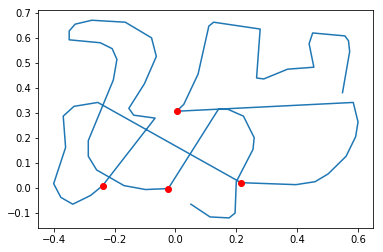

In [22]:
# (Load code from previous cell -- make sure to have executed above cell first.)
%run -i _derived/1_json_to_stroke.py

# Visualize / control output of json_to_stroke().

stroke = json_to_stroke(sample[3])
# First 2 dimensions are normalized dx/dy coordinates
# third dimension indicates "new stroke".
xy = stroke[:2, :].cumsum(axis=1)
pyplot.plot(*xy)
pxy = xy[:, stroke[2] != 0]
pyplot.plot(pxy[0], pxy[1], 'ro')

In [23]:
%%writefile _derived/1_make_example_stroke.py
# (Written into separate file for sharing between notebooks.)

# Convert drawing tf.train.Example proto.
# Uses json_to_stroke() from previous cell to create raster image.

def make_example_stroke(label, drawing):
    example = tf.train.Example()
    example.features.feature['label'].int64_list.value.append(label)
    stroke = json_to_stroke(drawing)
    example.features.feature['stroke_x'].float_list.value.extend(stroke[0, :])
    example.features.feature['stroke_y'].float_list.value.extend(stroke[1, :])
    example.features.feature['stroke_z'].float_list.value.extend(stroke[2, :])
    example.features.feature['stroke_len'].int64_list.value.append(stroke.shape[1])
    example.features.feature['countrycode'].bytes_list.value.append(drawing['countrycode'].encode())
    example.features.feature['recognized'].int64_list.value.append(drawing['recognized'])
    example.features.feature['word'].bytes_list.value.append(drawing['word'].encode())
    ts = drawing['timestamp']
    ts = time.mktime(time.strptime(ts[:ts.index('.')], '%Y-%m-%d %H:%M:%S'))
    example.features.feature['timestamp'].int64_list.value.append(long(ts))
    example.features.feature['key_id'].int64_list.value.append(long(drawing['key_id']))
    return example

Overwriting _derived/1_make_example_stroke.py


In [24]:
# (Load code from previous cell -- make sure to have executed above cell first.)
%run -i _derived/1_make_example_stroke.py

# Create the (stroke) dataset.

path = '%s/dataset_stroke' % data_path
t0 = time.time()
n = make_sharded_files(
    make_example=make_example_stroke,
    path=path,
    classes=classes,
    iters=[loaditer(name) for name in classes],
    splits=dict(train=50000, eval=10000, test=10000),
    overwrite=True,
)

print 'stored examples to "%s"' % path
print 'generated %d examples in %d seconds' % (n, time.time() - t0)

processed 2047/70000 (2.92%)
processed 4381/70000 (6.26%)
processed 6655/70000 (9.51%)
processed 8840/70000 (12.63%)
processed 10913/70000 (15.59%)
processed 13184/70000 (18.83%)
processed 15391/70000 (21.99%)
processed 17677/70000 (25.25%)
processed 19939/70000 (28.48%)
processed 22255/70000 (31.79%)
processed 24515/70000 (35.02%)
processed 26726/70000 (38.18%)
processed 28894/70000 (41.28%)
processed 30940/70000 (44.20%)
processed 33007/70000 (47.15%)
processed 35298/70000 (50.43%)
processed 37525/70000 (53.61%)
processed 39659/70000 (56.66%)
processed 41966/70000 (59.95%)
processed 44306/70000 (63.29%)
processed 46634/70000 (66.62%)
processed 48664/70000 (69.52%)
processed 50801/70000 (72.57%)
processed 52929/70000 (75.61%)
processed 54648/70000 (78.07%)
processed 56763/70000 (81.09%)
processed 58827/70000 (84.04%)
processed 60914/70000 (87.02%)
processed 63059/70000 (90.08%)
processed 65194/70000 (93.13%)
processed 67279/70000 (96.11%)
processed 69398/70000 (99.14%)
stored examples